<a href="https://colab.research.google.com/github/anmolsabharwal/RedDevils/blob/master/RD_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing Important libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from google.colab import drive
import datetime
import plotly.figure_factory as ff


drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
#connection to .db file
gws = sqlite3.connect('/content/drive/My Drive/fpl.db')
gws = pd.read_sql_query("SELECT * FROM gw",gws)
#gws1=pd.read_csv(io.StringIO(uploaded['gws.csv'].decode('utf-8')),sep=',')
gws.tail()


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
88499,Youri Tielemans,0,0,20,0,24.5,448,342,4,0,5.7,20.2,2020-07-12T18:00:00Z,90,3,0,0,0,0,44,0,290364,1,4,12,2,-1468,3543,5011,61,FALSE,0,149
88500,Yves Bissouma,0,0,8,0,1.9,53,343,5,0,0.7,5.4,2020-07-11T19:00:00Z,90,11,0,0,0,0,44,0,1910,5,0,0,1,50,117,67,50,TRUE,1,149
88501,Zech Medley,0,0,0,0,0,636,348,0,0,0,0,2020-07-12T15:30:00Z,0,17,0,0,0,0,44,0,1831,1,2,0,0,167,316,149,40,FALSE,0,149
88502,Çaglar Söyüncü,0,0,5,0,0.8,164,342,4,0,1,7.4,2020-07-12T18:00:00Z,66,3,0,0,0,1,44,0,1253775,1,4,2,-3,32374,51603,19229,50,FALSE,0,149
88503,Ørjan Nyland,0,0,0,0,0,27,341,0,0,0,0,2020-07-12T13:15:00Z,0,7,0,0,0,0,44,0,31410,0,2,0,0,-1673,413,2086,43,TRUE,0,149


In [121]:
gws.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'gw'],
      dtype='object')

In [122]:
#converting the datatypes of columns
gws=gws.astype({'name':'category','assists':int, 'bonus':int, 'bps':int, 'clean_sheets':int,
       'creativity':float,'element':int,'goals_conceded':int,
       'goals_scored':int, 'ict_index':float, 'influence':float,'minutes':int, 'opponent_team':int, 'own_goals':int,'penalties_missed':int, 'penalties_saved':int,
       'red_cards':int, 'round':int, 'saves':int, 'selected':int,
        # 'team_a_score':int, 'team_h_score':int,
        'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,
       'value':int, 'yellow_cards':int})

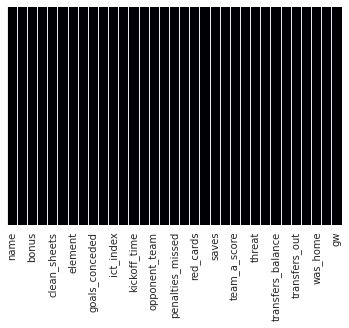

In [123]:
# cheking for null values
sns.set_style('dark')
sns.heatmap(gws.isnull(),yticklabels=False,cbar=False,cmap='inferno')

In [124]:
#assigning id to each specific player
gws = gws.assign(id=(gws['name']).astype('category').cat.codes)


In [125]:
gws= gws[gws['minutes'] > 0] 


In [126]:
# a function to decide the fixture difficulty ratio based on the position of the opponent team
def fd(x):
  x=int(x)
  if x<=6:
    return '3'
  elif x>6 and x<=14:
    return '1'
  else:
    return '2'

In [127]:
gws.rename(columns={'opponent_team':'fdr'},inplace=True)


In [128]:
gws['fdr']=gws['fdr'].apply(fd).astype(float)


In [129]:
gws['kickoff_time']=pd.to_datetime(gws['kickoff_time'])

In [130]:
gws['kickoff_time'] = gws.kickoff_time.dt.hour


In [131]:
#divind the kickoff time into 3 categories 
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [132]:
gws['kickoff_time']=gws['kickoff_time'].apply(time).astype(float)
gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,1,0,13918,1,1,0.0,1,0,0,0,60,TRUE,0,1,2
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,1,0,163170,4,3,23.0,2,0,0,0,80,TRUE,0,1,5
5,Abel Hern�ndez,1,0,10,0,12.2,163,4,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,1,0,26039,1,2,30.0,5,0,0,0,60,TRUE,0,1,13
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,1,0,38151,1,2,45.0,8,0,0,0,45,TRUE,0,1,29
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,1,0,17663,1,1,9.0,2,0,0,0,45,TRUE,0,1,17
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,1,0,2723,1,1,0.0,1,0,0,0,45,TRUE,1,1,19
10,Adam Lallana,1,2,33,0,33.7,205,8,3,1,14.2,51.2,1.0,75,3.0,0,0,0,0,1,0,155525,4,3,57.0,11,0,0,0,70,FALSE,1,1,21
13,Adam Smith,0,0,23,0,4.3,34,9,3,1,7.4,42.4,0.0,90,1.0,0,0,0,0,1,0,21505,3,1,27.0,7,0,0,0,45,TRUE,0,1,26
14,Adl�ne Gu�dioura,0,0,7,0,13.7,415,7,1,0,2.2,5.6,1.0,72,1.0,0,0,0,0,1,0,1330,1,1,3.0,1,0,0,0,45,FALSE,1,1,34
15,Adnan Januzaj,0,0,4,0,0.3,261,5,1,0,0.4,3.2,1.0,27,1.0,0,0,0,0,1,0,26092,1,2,0.0,1,0,0,0,55,FALSE,0,1,35


In [133]:
# setting up the 'was_home' column to create binary attributes
def was_home(a):
  if a=="FALSE":
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [134]:
gws['home']=gws['was_home'].apply(was_home)

In [135]:
#dropping columns that are not required
gws.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [136]:
gws['value']=gws['value']*0.1



In [137]:
# a fucntion to put the points into the bins. This is where the business problem is convereted froma regression to a classification problem
def points(x):
  if x<=1:
    return 1
  elif x>2 and x<=8:
    return 2
  # elif x>5 and x<=8:
  #  return 3
  # elif x>7 and x<=10:
  #   return 4
  else:
    return 3


In [138]:
gws['points']=gws['total_points'].apply(points)
gws1=gws.copy()


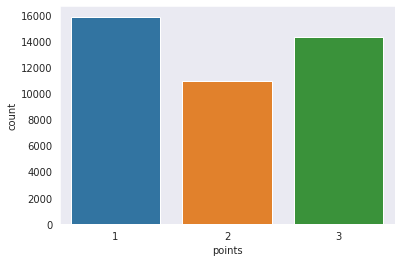

In [139]:
sns.countplot(gws1['points'])

In [140]:
#creating lags for different attributes

gws1['Last_Week_Points'] = gws1.groupby(['id'])['points'].shift().astype(float)
gws1['Last_2_Week_Points'] = gws1.groupby(['id'])['points'].shift(2).astype(float)
#gws1['Last_3_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(3).astype(float)
#gws1['Last_4_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(4).astype(float)



gws1['Last_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift().astype(float)
gws1['Last_2_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(2).astype(float)
#gws1['Last_3_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(3).astype(float)


gws1['Last_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift().astype(float)
gws1['Last_2_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(2).astype(float)
# #gws1['Last_3_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(3).astype(float)


gws1['Last_Week_BPS'] = gws1.groupby(['id'])['bps'].shift().astype(float)
gws1['Last_2_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(2).astype(float)
#gws1['Last_3_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(3).astype(float)


gws1['Last_Week_Assists'] = gws1.groupby(['id'])['assists'].shift().astype(float)
gws1['Last_2_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(2).astype(float)
#gws1['Last_3_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(3).astype(float)


gws1['Last_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift().astype(float)
gws1['Last_2_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(2).astype(float)
#gws1['Last_3_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(3).astype(float)


gws1['Last_Week_Influence'] = gws1.groupby(['id'])['influence'].shift().astype(float)
gws1['Last_2_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(2).astype(float)
#gws1['Last_3_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(3).astype(float)


gws1['Last_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift().astype(float)
gws1['Last_2_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(2).astype(float)
#gws1['Last_3_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(3).astype(float)


gws1['Last_Week_Threat'] = gws1.groupby(['id'])['threat'].shift().astype(float)
gws1['Last_2_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(2).astype(float)
# #gws1['Last_3_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(3).astype(float)


gws1['Last_Week_Selected'] = gws1.groupby(['id'])['selected'].shift().astype(float)
gws1['Last_2_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(2).astype(float)
#gws1['Last_3_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(3).astype(float)


gws1['Last_Week_Value'] = gws1.groupby(['id'])['value'].shift().astype(float)
gws1['Last_2_Week_Value'] = gws1.groupby(['id'])['value'].shift(2).astype(float)
# gws1['Last_3_Week_Value'] = gws1.groupby(['id'])['value'].shift(3).astype(float)


gws1['Last_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift().astype(float)
gws1['Last_2_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(2).astype(float)
# #gws1['Last_3_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(3).astype(float)



gws1['Last_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift().astype(float).astype(float)
gws1['Last_2_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
gws1['Last_3_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


gws1['Last_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift().astype(float)
gws1['Last_2_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#gws1['Last_3_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(3).astype(float)


gws1['Last_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift().astype(float)
gws1['Last_2_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#gws1['Last_3_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# gws1['Last_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift().astype(float)
# gws1['Last_2_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# gws1['Last_3_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(3).astype(float)


gws1['Last_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift().astype(float)
gws1['Last_2_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(2).astype(float)
# gws1['Last_3_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(3).astype(float)


gws1['Last_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift().astype(float)
gws1['Last_2_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# gws1['Last_3_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(3).astype(float)


gws1['Last_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift().astype(float)
gws1['Last_2_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(2).astype(float)


gws1['Last_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift().astype(float)
gws1['Last_2_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(2).astype(float)
# gws1['Last_3_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(3).astype(float)


gws1['Last_Week_Saves'] = gws1.groupby(['id'])['saves'].shift()
gws1['Last_2_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(2)
#gws1['Last_3_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(3)


gws1['Last_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift()
gws1['Last_2_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(2)
# gws1['Last_3_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(3)


# gws1['Last_Week_Home'] = gws1.groupby(['id'])['home'].shift()
# gws1['Last_2_Week_Home'] = gws1.groupby(['id'])['home'].shift(2)
# gws1['Last_3_Week_Home'] = gws1.groupby(['id'])['home'].shift(3)


gws1.head(100)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,points,Last_Week_Points,Last_2_Week_Points,Last_Week_Goals,Last_2_Week_Goals,Last_Week_ICT,Last_2_Week_ICT,Last_Week_BPS,Last_2_Week_BPS,Last_Week_Assists,Last_2_Week_Assists,Last_Week_Bonus,Last_2_Week_Bonus,Last_Week_Influence,Last_2_Week_Influence,Last_Week_Minutes_Played,Last_2_Week_Minutes_Played,Last_Week_Threat,Last_2_Week_Threat,Last_Week_Selected,Last_2_Week_Selected,Last_Week_Value,Last_2_Week_Value,Last_Week_Creativity,Last_2_Week_Creativity,Last_Week_FDR,Last_2_Week_FDR,Last_3_Week_FDR,Last_Week_Clean_Sheets,Last_2_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_2_Week_Goals_Conceded,Last_Week_Own_Goals,Last_2_Week_Own_Goals,Last_Week_Penalties_Missed,Last_2_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_2_Week_Penalties_Saved,Last_Week_Red_Cards,Last_2_Week_Red_Cards,Last_Week_Saves,Last_2_Week_Saves,Last_Week_Yellow_Cards,Last_2_Week_Yellow_Cards
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Abel Hern�ndez,1,0,10,0,12.2,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,0,26039,30.0,5,6.0,0,1,13,Home,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Adama Diomande,0,2,29,0,16.8,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,0,38151,45.0,8,4.5,0,1,29,Home,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adam Clayton,0,0,6,0,2.2,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,0,17663,9.0,2,4.5,0,1,17,Home,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Adam Forshaw,0,0,3,0,1.3,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,0,2723,0.0,1,4.5,1,1,19,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Adam Lallana,1,2,33,0,33.7,3,1,14.2,51.2,1.0,75,3.0,0,0,0,0,0,155525,57.0,11,7.0,1,1,21,Away,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Adam Smith,0,0,23,0,4.3,3,1,7.4,42.4,0.0,90,1.0,0,0,0,0,0,21505,27.0,7,4.5,0,1,26,Home,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Adl�ne Gu�dioura,0,0,7,0,13.7,1,0,2.2,5.6,1.0,72,1.0,0,0,0,0,0,1330,3.0,1,4.5,1,1,34,Away,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Adnan Januzaj,0,0,4,0,0.3,1,0,0.4,3.2,1.0,27,1.0,0,0,0,0,0,26092,0.0,1,5.5,0,1,35,Away,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
#creating binary attributes for was_home

home=pd.get_dummies(gws1['home'])
gws1=pd.concat([gws1,home],axis=1)
gws1.head()


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,points,Last_Week_Points,Last_2_Week_Points,Last_Week_Goals,Last_2_Week_Goals,Last_Week_ICT,Last_2_Week_ICT,Last_Week_BPS,Last_2_Week_BPS,Last_Week_Assists,Last_2_Week_Assists,Last_Week_Bonus,Last_2_Week_Bonus,Last_Week_Influence,Last_2_Week_Influence,Last_Week_Minutes_Played,Last_2_Week_Minutes_Played,Last_Week_Threat,Last_2_Week_Threat,Last_Week_Selected,Last_2_Week_Selected,Last_Week_Value,Last_2_Week_Value,Last_Week_Creativity,Last_2_Week_Creativity,Last_Week_FDR,Last_2_Week_FDR,Last_3_Week_FDR,Last_Week_Clean_Sheets,Last_2_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_2_Week_Goals_Conceded,Last_Week_Own_Goals,Last_2_Week_Own_Goals,Last_Week_Penalties_Missed,Last_2_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_2_Week_Penalties_Saved,Last_Week_Red_Cards,Last_2_Week_Red_Cards,Last_Week_Saves,Last_2_Week_Saves,Last_Week_Yellow_Cards,Last_2_Week_Yellow_Cards,Away,Home
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
5,Abel Hern�ndez,1,0,10,0,12.2,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,0,26039,30.0,5,6.0,0,1,13,Home,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
6,Adama Diomande,0,2,29,0,16.8,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,0,38151,45.0,8,4.5,0,1,29,Home,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
7,Adam Clayton,0,0,6,0,2.2,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,0,17663,9.0,2,4.5,0,1,17,Home,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [ ]:
#feature engineered a number of variables to better define the dependent variable

hpm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Home Points"] = hpm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Away Points"] = apm.reset_index(level=0, drop=True)

ppm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =gws1.groupby('id',as_index=False)['value'].expanding().sum()/gws1.groupby('id',as_index=False)['total_points'].expanding().sum()*90
gws1["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Assists_90"] = ppm.reset_index(level=0, drop=True)

gpm =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =gws1.groupby('id',as_index=False)['bps'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["BPS_90"] = ipm.reset_index(level=0, drop=True)

ih =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Home Influence"] = ih.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Away Influence"] = ah.reset_index(level=0, drop=True)

hg =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Home Goals"] = hg.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Goals_Conceded_Ratio"] = gc.reset_index(level=0, drop=True)

s =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Save per min"] = s.reset_index(level=0, drop=True)

sh =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Saves Home"] = sh.reset_index(level=0, drop=True)

sa =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Saves Away"] = sa.reset_index(level=0, drop=True)

ch =gws1.groupby('id',as_index=False)['creativity'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Creativity Home"] = ch.reset_index(level=0, drop=True)

ca =gws1.groupby('id',as_index=False)['creativity'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Creativity Away"] = ca.reset_index(level=0, drop=True)

csh =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Clean Sheets Home"] = csh.reset_index(level=0, drop=True)

csa =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Clean Sheets Away"] = csa.reset_index(level=0, drop=True)

bph =gws1.groupby('id',as_index=False)['bonus'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1['Bonus Home'] = bph.reset_index(level=0, drop=True)

bpa =gws1.groupby('id',as_index=False)['bonus'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Bonus Away"] = bpa.reset_index(level=0, drop=True)

icth =gws1.groupby('id',as_index=False)['ict_index'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1['ICT Home'] = icth.reset_index(level=0, drop=True)

icta =gws1.groupby('id',as_index=False)['ict_index'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["ICT Away"] = icta.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1['Assists Home'] = ah.reset_index(level=0, drop=True)

aa =gws1.groupby('id',as_index=False)['ict_index'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Assists Away"] = aa.reset_index(level=0, drop=True)

# ms =gws1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/gws1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# gws1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['bps'].expanding().sum()
gws1["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Goals Concecded Away"] = gca.reset_index(level=0, drop=True)

gch =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gcm =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()
gws1["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)



In [26]:
# gws1['dummy1']=gws1['goals_scored']
# gws1['dummy2']=gws1['clean_sheets']


In [27]:
# a function to capture the goal scoring streak of a player
def f(df):
    df['Goalstreak'] = (df['goals_scored'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['goals_scored'] == 0, 'cumsum'] = df['Goalstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Goal Streak'] = df['Goalstreak'] - df['cumsum']
    df.drop(['Goalstreak', 'cumsum'], axis=1, inplace=True)
    df['Goal Streak']=df['Goal Streak'].shift(1)
    return df


In [28]:
gws1=gws1.groupby('id').apply(f)


In [29]:
def f2(df):
    df['csstreak'] = (df['clean_sheets'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['clean_sheets'] == 0, 'cumsum'] = df['csstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Clean Sheet Streak'] = df['csstreak'] - df['cumsum']
    df.drop(['csstreak', 'cumsum'], axis=1, inplace=True)
    df['Clean Sheet Streak']=df['Clean Sheet Streak'].shift(1)
    return df


In [30]:
gws1=gws1.groupby('id').apply(f2)

In [31]:
def f3(df):
    df['psstreak'] = (df['penalties_saved'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['penalties_saved'] == 0, 'cumsum'] = df['psstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Penalty Save Streak'] = df['psstreak'] - df['cumsum']
    df.drop(['psstreak', 'cumsum'], axis=1, inplace=True)
    df['Penalty Save Streak']=df['Penalty Save Streak'].shift(1)
    return df

In [32]:
gws1=gws1.groupby('id').apply(f3)

In [33]:
gws1.goals_scored.unique()

array([0, 1, 2, 3, 4])

In [34]:
#dropping all the NAn, inf values created because of feature engineering
gws1=gws1.replace([np.inf, -np.inf], np.nan)

gws1=gws1.dropna()
gws1.head(200)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,points,Last_Week_Points,Last_2_Week_Points,Last_Week_Goals,Last_2_Week_Goals,Last_Week_ICT,Last_2_Week_ICT,Last_Week_BPS,Last_2_Week_BPS,Last_Week_Assists,Last_2_Week_Assists,Last_Week_Bonus,Last_2_Week_Bonus,Last_Week_Influence,...,Last_Week_Saves,Last_2_Week_Saves,Last_Week_Yellow_Cards,Last_2_Week_Yellow_Cards,Away,Home,Home Points,Away Points,Points_90,Value_Point,Assists_90,Goals_90,Influence_90,BPS_90,Home Influence,Away Influence,Home Goals,Clean Sheets per Min,Points Per Min,Goals_Conceded_Ratio,Save per min,Saves Home,Saves Away,Creativity Home,Creativity Away,Clean Sheets Home,Clean Sheets Away,Bonus Home,Bonus Away,ICT Home,ICT Away,Assists Home,Assists Away,Mins Per BPS,Goals Concecded Away,Goals Conceded Home,Mins per Goals Conceded,Goal Streak,Clean Sheet Streak,Penalty Save Streak
1721,Aaron Cresswell,0,0,13,0,2.8,3,0,1.3,8.4,1.0,90,2.0,0,0,0,0,0,16187,2.0,1,5.3,0,4,1,Away,1,1.0,1.0,0.0,0.0,2.0,1.3,13.0,12.0,0.0,0.0,0.0,0.0,14.4,...,0.0,0.0,0.0,0.0,1,0,4.000000,1.333333,1.333333,481.500000,1.333333,0.0,9.400000,9.400000,28.200000,9.400000,0.0,0.0,0.000000,0.022222,0.000000,0.0,0.000000,12.60,4.200000,0.0,0.000000,0.0,0.000000,4.600000,1.533333,0.0,1.533333,7.105263,2.000000,6.000000,45.000000,0.0,0.0,0.0
1722,Aaron Lennon,0,0,6,0,3.2,1,0,0.6,0.0,1.0,65,2.0,0,0,0,0,0,7501,4.0,2,5.6,0,4,2,Home,1,1.0,1.0,0.0,0.0,0.7,0.4,6.0,6.0,0.0,0.0,0.0,0.0,5.6,...,0.0,0.0,0.0,0.0,0,1,1.666667,5.000000,3.913043,410.400000,3.913043,0.0,13.304348,13.304348,5.666667,17.000000,0.0,0.0,0.000000,0.017391,0.000000,0.0,0.000000,1.80,5.400000,0.0,0.000000,0.0,0.000000,0.866667,2.600000,0.0,2.600000,4.791667,2.000000,0.666667,57.500000,0.0,0.0,0.0
1723,Aaron Ramsey,0,0,-1,0,8.8,1,0,1.1,0.4,0.0,90,1.0,0,0,0,0,0,42010,2.0,1,7.6,1,4,5,Away,1,1.0,1.0,0.0,0.0,0.5,4.8,2.0,13.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,4.000000,4.000000,3.789474,346.500000,3.789474,0.0,8.810526,8.810526,9.300000,9.300000,0.0,0.0,0.000000,0.021053,0.000000,0.0,0.000000,18.95,18.950000,0.0,0.000000,0.0,0.000000,4.700000,4.700000,0.5,4.700000,10.000000,2.000000,2.000000,47.500000,0.0,0.0,0.0
1726,Abel Hern�ndez,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,2.0,0,0,0,0,0,48421,0.0,0,6.0,0,4,13,Away,1,1.0,1.0,0.0,0.0,0.3,5.5,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,4.000000,4.000000,3.829787,270.000000,3.829787,0.0,7.085106,7.085106,7.400000,7.400000,0.0,0.0,0.000000,0.015957,0.000000,0.0,0.000000,14.00,14.000000,0.0,0.000000,0.0,0.000000,5.750000,5.750000,0.5,5.750000,11.750000,1.500000,1.500000,62.666667,0.0,0.0,0.0
1727,Adama Diomande,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,2.0,0,0,0,0,0,220490,0.0,0,4.6,0,4,29,Away,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,4.000000,4.000000,8.000000,205.875000,8.000000,1.0,45.200000,45.200000,22.600000,22.600000,0.5,0.5,0.000000,0.011111,0.000000,0.0,0.000000,8.40,8.400000,0.0,0.000000,1.0,1.000000,5.350000,5.350000,0.0,5.350000,3.103448,0.500000,0.500000,90.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,Lewis Cook,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,16079,0.0,0,4.2,0,4,815,Away,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1.000000,1.000000,2.250000,778.500000,2.250000,0.0,7.875000,7.875000,3.500000,3.500000,0.0,0.0,0.000000,0.037500,0.000000,0.0,0.000000,7.15,7.150000,0.0,0.000000,0.0,0.000000,1.250000,1.250000,0.0,1.250000,8.000000,1.500000,1.500000,26.666667,0.0,0.0,0.0
2082,Loris Karius,0,0,20,1,0.0,0,0,0.2,2.0,1.0,90,1.0,0,0,0,0

In [35]:
#calculating the correaltion of the different variables with the dependent variable
c=gws1.corr().abs()
cor_target = c['total_points']
# relevant_features = cor_target[cor_target>0.3]
# relevant_features
pd.set_option('display.max_rows', None)
cor_target.sort_values(ascending=False)

total_points                    1.000000
bps                             0.900599
influence                       0.818903
bonus                           0.752192
ict_index                       0.742766
goals_scored                    0.664462
minutes                         0.603535
points                          0.578427
clean_sheets                    0.572409
threat                          0.525516
assists                         0.449624
creativity                      0.444159
Away Points                     0.429110
Home Points                     0.421578
Last_Week_Minutes_Played        0.398140
Away Influence                  0.384731
Home Influence                  0.377088
Assists Away                    0.372018
ICT Away                        0.372018
ICT Home                        0.365524
Bonus Away                      0.363091
Bonus Home                      0.358622
Clean Sheets Away               0.349960
Last_2_Week_Minutes_Played      0.348455
Clean Sheets Hom

In [36]:
#variance of each variable
gws1.var()

assists                         5.546502e-02
bonus                           2.867105e-01
bps                             1.098982e+02
clean_sheets                    1.134696e-01
creativity                      1.406716e+02
goals_conceded                  1.082073e+00
goals_scored                    6.461170e-02
ict_index                       1.091192e+01
influence                       1.939260e+02
kickoff_time                    2.831288e-01
minutes                         1.741365e+03
fdr                             6.894389e-01
own_goals                       1.714526e-03
penalties_missed                1.186509e-03
penalties_saved                 9.581107e-04
red_cards                       2.313216e-03
saves                           4.967885e-01
selected                        1.346415e+11
threat                          2.228417e+02
total_points                    7.225406e+00
value                           1.737071e+00
yellow_cards                    6.285436e-02
id        

In [37]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,Binarizer,scale
from imblearn.pipeline import Pipeline


In [109]:
#importing various other libraries and defining X and y set for testing and training
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from collections import Counter
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler

X=gws1.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id','fdr'],axis=1)
y=gws1['points']




In [110]:
#dividing the dataset into testing and training data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=101,stratify=y)
train_0, train_1 = len(y_train[y_train==1]), len(y_train[y_train==2])
test_0, test_1 = len(y_test[y_test==1]), len(y_test[y_test==2])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=45975, 1=838, Test: 0=22645, 1=413


In [40]:
# #since there is a class imbalance, we have undersampled the majority class
# from imblearn.under_sampling import NearMiss

# # define the undersampling method
# undersample = NearMiss(version=1, n_neighbors=3)
# # transform the dataset
# X_train, y_train = undersample.fit_resample(X_train, y_train)
# # summarize the new class distribution
# counter = Counter(y_train)
# print(counter)

In [41]:
# from imblearn.over_sampling import ADASYN

# # create the object to resample the majority class.
# adasyn = ADASYN(sampling_strategy="minority")

# # fit the object to the training data.
# X_train, y_train = adasyn.fit_sample(X_train, y_train)
# counter = Counter(y_train)
# print(counter)
# X_train.head()

In [104]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
counter = Counter(y_train_res)
print(counter)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Counter({1: 45975, 2: 45975})


In [43]:
# counter = Counter(y)
# print(counter)
# # define pipeline
# over = SMOTE(sampling_strategy=({1:,2:0.2,3:0.5}))
# under = RandomUnderSampler(sampling_strategy=({1:0.5,2:0.01,3:0.01}))
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# # transform the dataset
# X, y = pipeline.fit_resample(X, y)
# # summarize the new class distribution
# counter = Counter(y)
# print(counter)

In [105]:
#since we had a lot of attributes we decided the reduce it using PCA and scaled it
scaler= StandardScaler()
scaler.fit(X_train_res)
X_train=scaler.transform(X_train_res)
X_test=scaler.transform(X_test)
from sklearn.decomposition import PCA
pca = PCA(0.95)
pca.fit_transform(X_train_res)
X_train=pca.transform(X_train_res)
X_test=pca.transform(X_test)



array([[-460013.72458754],
       [-418561.81280652],
       [-171510.94637836],
       ...,
       [ 129015.1537268 ],
       [ 763617.28384224],
       [-165094.40510247]])

In [99]:
#evaluating different models and their performance
def evaluate_model(X_train, y_train, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
# define models to test
def get_models():
	models, names = list(), list()
	# LR
	models.append(LogisticRegression(solver='lbfgs', multi_class='multinomial'))
	names.append('LR')
	# LDA
	models.append(LinearDiscriminantAnalysis())
	names.append('LDA')
	# KNN
	models.append(KNeighborsClassifier(n_neighbors=3))
	names.append('KNN')
	return models, names

>LR 0.982 (0.000)
>LDA 0.968 (0.001)
>KNN 0.980 (0.000)


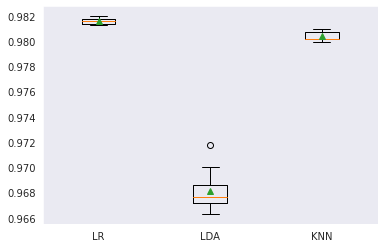

In [100]:
# define models
# scaler=StandardScaler()
# a=scaler.fit_transform(X_train)
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# evaluate the model and store results
	scores = evaluate_model(X_train, y_train, models[i])
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [92]:
#hyper parameter tuning
model=LogisticRegression()
solvers = ['newton-cg', 'lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: ignored

In [ ]:
# List Hyperparameters that we want to tune.
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(X,y)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [87]:
#training the model


#model=RandomForestClassifier()
#model=RandomForestRegressor()
#model=KNeighborsClassifier(leaf_size=1,p=2,n_neighbors=8)
model=LogisticRegression(class_weight='balanced')
#model=DecisionTreeClassifier()
#model=Lasso()
#model=Ridge()
#model=LinearRegression()
#model=sm.OLS(X_train,y_train)
#model=SGDRegressor(eta0=0.0001)
#model=LGBMRegressor()

# k_fold = KFold(n_splits=5)
# for train_indices, test_indices in k_fold.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
 
# [model.fit(X_train, y_train).score(X_test, y_test)
# for train, test in k_fold.split(X)]
cv = RepeatedKFold(n_splits=8, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# # # fit the model on the whole dataset
# # #model = GradientBoostingRegressor()


[0.63292878 0.67323105 0.64907259 0.67735287 0.65147699 0.64392031
 0.64815663 0.64170388 0.65445386 0.67735287 0.63544768 0.64460728
 0.65147699 0.64437829 0.69189375 0.68281232 0.68170369 0.65182047
 0.67414701 0.67059766 0.66006412 0.63602015 0.68456606 0.68178175]


In [88]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
#predicting the values 
predict=model.predict(X_test)


In [90]:
# predict = model.predict(X_test)
df=pd.DataFrame({'Actual':y_test,'Predicted':predict})
df.head(500)


,Actual,Predicted
43064,1,2
23940,1,1
36278,1,1
41518,1,1
28146,1,1
58798,1,1
29353,1,2
39566,1,1
47995,1,1
79032,1,1


In [91]:
#Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix,auc, roc_auc_score
print(classification_report(y_test,predict))
confusion_matrix(y_test,predict)

              precision    recall  f1-score   support

           1       0.99      0.68      0.81     34310
           2       0.04      0.81      0.08       626

    accuracy                           0.68     34936
   macro avg       0.52      0.75      0.45     34936
weighted avg       0.98      0.68      0.80     34936



array([[23378, 10932],
       [  119,   507]])

In [ ]:
model.score(X_test,y_test)

In [ ]:
sns.countplot(gws1['points'])

In [ ]:
x=pd.read_csv('/content/drive/My Drive/combined_2016-2020-1.csv',encoding = "ISO-8859-1")

x.tail()


In [ ]:
x=x.astype({'was_home':str})

In [ ]:
x = x.assign(id=(x['name']).astype('category').cat.codes)


In [ ]:
x.rename(columns={'opponent_team':'fdr'},inplace=True)


In [ ]:
# x['fdr']=x['fdr'].apply(fd).astype(float)


In [ ]:
x['kickoff_time']=pd.to_datetime(x['kickoff_time'])

In [ ]:
x['kickoff_time'] = x.kickoff_time.dt.hour

In [ ]:
x['kickoff_time']=x['kickoff_time'].apply(time).astype(float)
x.head(20)

In [ ]:
def was__home(a):
  if a=='False':
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [ ]:
x['home']=x['was_home'].apply(was__home)
x.head()

In [ ]:
x.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [ ]:
x['value']=x['value']*0.1


In [ ]:
x['points']=x['total_points'].apply(points)
x.head(100)

In [ ]:
home=pd.get_dummies(x['home'])
x=pd.concat([x,home],axis=1)
x.head(100)

In [ ]:
x['Last_Week_Points'] = x.groupby(['id'])['points'].shift().astype(float)
x['Last_2_Week_Points'] = x.groupby(['id'])['points'].shift(2).astype(float)
#x['Last_3_Week_Points'] = x.groupby(['id'])['total_points'].shift(3).astype(float)
#x['Last_4_Week_Points'] = x.groupby(['id'])['total_points'].shift(4).astype(float)



x['Last_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift().astype(float)
x['Last_2_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(2).astype(float)
#x['Last_3_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(3).astype(float)


x['Last_Week_ICT'] = x.groupby(['id'])['ict_index'].shift().astype(float)
x['Last_2_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(2).astype(float)
# #x['Last_3_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(3).astype(float)


x['Last_Week_BPS'] = x.groupby(['id'])['bps'].shift().astype(float)
x['Last_2_Week_BPS'] = x.groupby(['id'])['bps'].shift(2).astype(float)
#x['Last_3_Week_BPS'] = x.groupby(['id'])['bps'].shift(3).astype(float)


x['Last_Week_Assists'] = x.groupby(['id'])['assists'].shift().astype(float)
x['Last_2_Week_Assists'] = x.groupby(['id'])['assists'].shift(2).astype(float)
#x['Last_3_Week_Assists'] = x.groupby(['id'])['assists'].shift(3).astype(float)


x['Last_Week_Bonus'] = x.groupby(['id'])['bonus'].shift().astype(float)
x['Last_2_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(2).astype(float)
#x['Last_3_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(3).astype(float)


x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)
x['Last_2_Week_Penalties_Saved'] =x.groupby(['id'])['penalties_saved'].shift(2).astype(float)


x['Last_Week_Influence'] = x.groupby(['id'])['influence'].shift().astype(float)
x['Last_2_Week_Influence'] = x.groupby(['id'])['influence'].shift(2).astype(float)
#x['Last_3_Week_Influence'] = x.groupby(['id'])['influence'].shift(3).astype(float)


x['Last_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift().astype(float)
x['Last_2_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(2).astype(float)
#x['Last_3_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(3).astype(float)


x['Last_Week_Threat'] = x.groupby(['id'])['threat'].shift().astype(float)
x['Last_2_Week_Threat'] = x.groupby(['id'])['threat'].shift(2).astype(float)
# #x['Last_3_Week_Threat'] = x.groupby(['id'])['threat'].shift(3).astype(float)


x['Last_Week_Selected'] = x.groupby(['id'])['selected'].shift().astype(float)
x['Last_2_Week_Selected'] = x.groupby(['id'])['selected'].shift(2).astype(float)
#x['Last_3_Week_Selected'] = x.groupby(['id'])['selected'].shift(3).astype(float)


x['Last_Week_Value'] = x.groupby(['id'])['value'].shift().astype(float)
x['Last_2_Week_Value'] = x.groupby(['id'])['value'].shift(2).astype(float)
# x['Last_3_Week_Value'] = x.groupby(['id'])['value'].shift(3).astype(float)


x['Last_Week_Creativity'] = x.groupby(['id'])['creativity'].shift().astype(float)
x['Last_2_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(2).astype(float)
# #x['Last_3_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(3).astype(float)



x['Last_Week_FDR'] = x.groupby(['id'])['fdr'].shift().astype(float).astype(float)
x['Last_2_Week_FDR'] = x.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
x['Last_3_Week_FDR'] = x.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


x['Last_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift().astype(float)
x['Last_2_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#x['Last_3_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(3).astype(float)


x['Last_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift().astype(float)
x['Last_2_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#x['Last_3_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# x['Last_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift().astype(float)
# x['Last_2_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# x['Last_3_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(3).astype(float)


x['Last_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift().astype(float)
x['Last_2_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(2).astype(float)
# x['Last_3_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(3).astype(float)


x['Last_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift().astype(float)
x['Last_2_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# x['Last_3_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift(3).astype(float)


x['Last_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift().astype(float)
x['Last_2_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(2).astype(float)
# x['Last_3_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(3).astype(float)


x['Last_Week_Saves'] = x.groupby(['id'])['saves'].shift()
x['Last_2_Week_Saves'] = x.groupby(['id'])['saves'].shift(2)
#x['Last_3_Week_Saves'] = x.groupby(['id'])['saves'].shift(3)


x['Last_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift()
x['Last_2_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(2)
# x['Last_3_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(3)


# x['Last_Week_Home'] = x.groupby(['id'])['home'].shift()
# x['Last_2_Week_Home'] = x.groupby(['id'])['home'].shift(2)
# x['Last_3_Week_Home'] = x.groupby(['id'])['home'].shift(3)
hpm =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Home Points"] = hpm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Away Points"] = apm.reset_index(level=0, drop=True)

ppm =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =x.groupby('id',as_index=False)['value'].expanding().sum()/x.groupby('id',as_index=False)['total_points'].expanding().sum()*90
x["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['assists'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Assists_90"] = ppm.reset_index(level=0, drop=True)

gpm =x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =x.groupby('id',as_index=False)['bps'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["BPS_90"] = ipm.reset_index(level=0, drop=True)

ih =x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Home Influence"] = ih.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Away Influence"] = ah.reset_index(level=0, drop=True)

hg =x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Home Goals"] = hg.reset_index(level=0, drop=True)

ag =x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Clean Sheets_90"] = ag.reset_index(level=0, drop=True)

cs =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Points_90"] = cs.reset_index(level=0, drop=True)

gc =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Goals_Conceded_90"] = gc.reset_index(level=0, drop=True)

s =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Saves_90"] = s.reset_index(level=0, drop=True)

sh =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Saves Home"] = sh.reset_index(level=0, drop=True)

sa =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Saves Away"] = sa.reset_index(level=0, drop=True)

ch =x.groupby('id',as_index=False)['creativity'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Creativity Home"] = ch.reset_index(level=0, drop=True)

ca =x.groupby('id',as_index=False)['creativity'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Creativity Away"] = ca.reset_index(level=0, drop=True)

csh =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Clean Sheets Home"] = csh.reset_index(level=0, drop=True)

csa =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Clean Sheets Away"] = csa.reset_index(level=0, drop=True)

bph =x.groupby('id',as_index=False)['bonus'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x['Bonus Home'] = bph.reset_index(level=0, drop=True)

bpa =x.groupby('id',as_index=False)['bonus'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Bonus Away"] = bpa.reset_index(level=0, drop=True)

icth =x.groupby('id',as_index=False)['ict_index'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x['ICT Home'] = icth.reset_index(level=0, drop=True)

icta =x.groupby('id',as_index=False)['ict_index'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["ICT Away"] = icta.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['assists'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x['Assists Home'] = ah.reset_index(level=0, drop=True)

aa =x.groupby('id',as_index=False)['ict_index'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Assists Away"] = aa.reset_index(level=0, drop=True)

# ms =gws1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/gws1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# gws1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum()
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Goals Concecded Away"] = gca.reset_index(level=0, drop=True)

gch =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)


x.head(100)

In [ ]:
x=x.groupby('id').apply(f)
x=x.groupby('id').apply(f2)
x=x.groupby('id').apply(f3)

In [ ]:
x1=x[x['gw']==150]
x1.head(40)

In [ ]:
x_test=x1.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id','fdr'],axis=1)
x_test=x_test.replace([np.inf, -np.inf], np.nan)
x_test=x_test.dropna()
x_testf=x1.drop(['points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home'],axis=1)
x_testf=x_testf.replace([np.inf, -np.inf], np.nan)
x_testf=x_testf.dropna()
x_test.head(100)


In [ ]:
x_test1=scaler.fit_transform(x_test)
x_test2=pca.transform(x_test1)
predict1=model.predict(x_test2)


In [ ]:
predict1=pd.DataFrame(predict1)
predict1.head(100)
df1 = pd.concat([x_testf.reset_index(drop='Tru‌​e'),predict1.reset_index(drop='Tru‌​e')],axis=1)
df1.head()


In [ ]:
df1.to_csv('/content/drive/My Drive/29.csv')